In [37]:
import graph_tool.all as gt
import pandas as pd
import glob
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
gt.show_config()

version: 2.2.44dev (commit 85f11ae8, Thu Jun 18 15:33:16 2015 +0200)
gcc version: 4.8.4
compilation flags:  -I/usr/include/python3.4m -I/usr/include -I/usr/local/lib/python3.4/dist-packages/numpy/core/include   -DSPARSEHASH_PREFIX=sparsehash -Wall -Wextra -ftemplate-backtrace-limit=0  -DNDEBUG -std=gnu++11 -ftemplate-depth-250 -Wno-deprecated -Wno-unknown-pragmas -O3 -fvisibility=default -fvisibility-inlines-hidden -fopenmp   -DSPARSEHASH_PREFIX=sparsehash  -L/usr/lib -lpython3.4m
install prefix: /usr/local
python dir: /usr/lib/python3/dist-packages
graph filtering: True
openmp: True
uname: Linux barahv2 3.13.0-45-generic #74-Ubuntu SMP Tue Jan 13 19:36:28 UTC 2015 x86_64


In [39]:
df = pd.read_csv('/home/aahu/Dropbox/black-market-recommender-systems/data/ev_item_sim.tsv',sep='\t')
#df = pd.read_csv('/home/aahu/Dropbox/black-market-recommender-systems/data/df_all_item_sim.tsv',sep='\t')

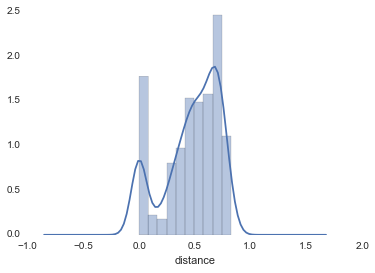

count    5.460000e+02
mean     4.730751e-01
std      2.469968e-01
min     -2.220446e-16
25%      3.382893e-01
50%      5.232503e-01
75%      6.789978e-01
max      8.250250e-01
Name: distance, dtype: float64

In [40]:
sns.distplot(df['distance'])
plt.show()
df['distance'].describe()

In [41]:
df2 = df[df['distance'] < df['distance'].quantile(1)]
df2 = df
df2 = df2[df2['category'] != df2['similar']]
print(df2['category'].unique().shape)
df2.shape

(78,)


(468, 4)

In [42]:
def build_cat_cat_net(df_in):
    
    df = df_in.copy(deep=True)  # python mutable arguments...
    
    #filter to most common cats
    cats = set(df['category']).union(set(df['similar']))
    
    #build graph-tool ids
    node_lbs = {}
    rev_node_lbs = {}
    for idx,cat in enumerate(cats):
        node_lbs[cat] = idx
        rev_node_lbs[idx] = cat
    
    edge_list = []
    edge_ws = {}
    MAX_DIST = df['distance'].max()
    for row in df.iterrows():
        edge = tuple(sorted((node_lbs[row[1]['category']], node_lbs[row[1]['similar']])))
        edge_list.append(edge)
        edge_ws[edge] = MAX_DIST - row[1]['distance']

    g = gt.Graph(directed=False)
    g.add_edge_list(edge_list)
    
    g.vertex_properties['label'] = g.new_vertex_property('string')
    for v in g.vertices():
        g.vertex_properties['label'][v] = rev_node_lbs[g.vertex_index[v]]
    print('g vert/edges: ',g.num_vertices(), g.num_edges())
    
    #add edge weight property
    g.edge_properties['weight'] = g.new_edge_property('double')
    g.edge_properties['color'] = g.new_edge_property('vector<double>')
    for e in g.edges():
        w = edge_ws[tuple(sorted([e.source(),e.target()]))]
        g.edge_properties['weight'][e] = w
        alpha = w + .125
        g.edge_properties['color'][e] = [103/255.0,134/255.0,239/255.0,alpha]  
        
    print([v.out_degree() for v in g.vertices()])
    
    state = gt.minimize_nested_blockmodel_dl(g, 
                                             deg_corr=True,
                                             weight=g.ep['weight'],
                                             verbose=True)
    
    #this 'draw' is only to get the node coords sorted out
    pos,t,tpos = gt.draw_hierarchy(state,
                      vertex_text=g.vertex_properties['label'],
                      vertex_text_position=1,
                      vertex_font_size=20,
                      vertex_font_family='mono',
                      vertex_anchor=0,
                      vcmap=matplotlib.cm.Spectral,
                      ecmap=matplotlib.cm.Spectral,
                      bg_color=[0,0,0,1],
                      output_size=[1024*2,1024*2],
                      output='/tmp/badtext.png')
    
    #text rotation
    text_rot = g.new_vertex_property('double')
    g.vertex_properties['text_rot'] = text_rot
    text_pos = g.new_vertex_property('double')
    g.vertex_properties['text_pos'] = text_pos
    for v in g.vertices():
        if pos[v][0] > 0:
            text_rot[v] = math.atan(pos[v][1]/pos[v][0])
        else:
            text_rot[v] = math.atan(pos[v][1]/pos[v][0])
            text_pos[v] = 10
    
    print('drawing again, with rotation')
    pos,t,tpos = gt.draw_hierarchy(state,
                  vertex_text=g.vertex_properties['label'],
                  vertex_text_rotation=g.vertex_properties['text_rot'],
                  vertex_text_position=g.vp['text_pos'],
                  vertex_font_size=13,
                  vertex_font_family='mono',
                  vertex_anchor=0,
                  halpha=0, hsize_scale=0,
                  vcmap=matplotlib.cm.Spectral,
                  ecmap=matplotlib.cm.Spectral,
                  bg_color=[0,0,0,1],
                  output_size=[2600,2600],
                  fit_view=.75,
                  output='/home/aahu/Desktop/similarity_df_all.png')
            
    return

build_cat_cat_net(df2)

g vert/edges:  78 468
[10, 13, 14, 10, 12, 21, 17, 9, 8, 10, 13, 11, 11, 14, 8, 9, 9, 15, 10, 13, 9, 14, 11, 10, 17, 15, 8, 13, 13, 11, 14, 9, 10, 11, 13, 14, 15, 16, 15, 16, 17, 9, 12, 12, 15, 10, 11, 12, 10, 10, 10, 12, 11, 12, 10, 12, 16, 11, 9, 11, 7, 17, 19, 9, 11, 14, 10, 12, 9, 11, 11, 9, 7, 16, 8, 11, 13, 19]
level 0 : resizing 78 -> 6 , dS: -544.0455019514075
level 1 : resizing 1 -> 1 , dS: 0.0 [kept, rejected (1, 81.0761) vs (1, 81.0761)]
level 0 : skipping 6
drawing again, with rotation


In [43]:
def build_cat_net_from_shared_vendors(df):
    #build graph-tool ids
    node_lbs = {}
    rev_node_lbs = {}
    for idx,vendor in enumerate(df['category'].drop_duplicates()):
        node_lbs[vendor] = idx
        rev_node_lbs[idx] = vendor
    df['id'] = df['category'].map(lambda x:node_lbs[x])
    
    edge_list = []
    dfg = df.groupby('vendor')
    for name,group in dfg:
        ei = itertools.combinations(group['id'].drop_duplicates(),2)
        for e in ei:
            edge_list.append(tuple(sorted(e)))

    #filter edges by num shared vendors
    MIN_SHARED_VENDORS=3
    c = collections.Counter(edge_list)
    edge_list = [e for e in c if c[e]>=MIN_SHARED_VENDORS]

    #build graph
    g = gt.Graph(directed=False)
    g.add_edge_list(edge_list)
    g.vertex_properties['label'] = g.new_vertex_property('string')
    for v in g.vertices():
        g.vertex_properties['label'][v] = rev_node_lbs[g.vertex_index[v]]
    print('g vert/edges: ',g.num_vertices(), g.num_edges())

    #add edge weight property
    g.edge_properties['weight'] = g.new_edge_property('double')
    g.edge_properties['color'] = g.new_edge_property('vector<double>')
    for e in g.edges():
        w = c[tuple(sorted([e.source(),e.target()]))]
        g.edge_properties['weight'][e] = w
        alpha = (float(w)/max(c.values())) + .025
        g.edge_properties['color'][e] = [103/255.0,134/255.0,239/255.0,alpha] 
        
    state = gt.minimize_nested_blockmodel_dl(g,
                                             deg_corr=True,
                                             eweight=g.ep['weight'], 
                                             verbose=True,
                                            max_B=9)
    
    pos,t,tpos = gt.draw_hierarchy(state,
                      vertex_text=g.vertex_properties['label'],
                      vertex_text_position=1,
                      vertex_font_size=20,
                      vertex_font_family='mono',
                      vertex_anchor=0,
                      vcmap=matplotlib.cm.Spectral,
                      ecmap=matplotlib.cm.Spectral,
                      bg_color=[0,0,0,1],
                      output_size=[1024*2,1024*2],
                      output='/home/aahu/Desktop/cats_from_vends.png')
    
    #text rotation
    text_rot = g.new_vertex_property('double')
    g.vertex_properties['text_rot'] = text_rot
    text_pos = g.new_vertex_property('double')
    g.vertex_properties['text_pos'] = text_pos
    for v in g.vertices():
        if pos[v][0] > 0:
            text_rot[v] = math.atan(pos[v][1]/pos[v][0])
        else:
            text_rot[v] = math.atan(pos[v][1]/pos[v][0])
            text_pos[v] = 10 #len(g.vp['label'][v].strip())

#     #text rotation
# text_rot = g.new_vertex_property('double')
# g.vertex_properties['text_rot'] = text_rot
# for v in g.vertices():
#     if pos[v][0] >0:
#         text_rot[v] = math.atan(pos[v][1]/pos[v][0])
#     else:
#         text_rot[v] = math.pi + math.atan(pos[v][1]/pos[v][0])
    
    print('drawing again, with rotation')
    pos,t,tpos = gt.draw_hierarchy(state,
                  vertex_text=g.vertex_properties['label'],
                  vertex_text_rotation=g.vertex_properties['text_rot'],
                  vertex_text_position=g.vp['text_pos'],
                  vertex_font_size=18,
                  vertex_font_family='mono',
                  vertex_anchor=0,
                  vcmap=matplotlib.cm.Spectral,
                  ecmap=matplotlib.cm.Spectral,
                  bg_color=[0,0,0,1],
                  output_size=[1024*2,1024*2],
                  output='/home/aahu/Desktop/cats_from_vends.png')
    return

df3 = pd.read_csv('/home/aahu/Dropbox/black-market-recommender-systems/data/evolution.tsv',sep='\t')
build_cat_net_from_shared_vendors(df3)

g vert/edges:  76 2246
level 0 : resizing 76 -> 9 , dS: -4744.86026056495
level 1 : resizing 1 -> 2 , dS: -2.19109615384
level 2 : resizing 1 -> 1 , dS: 0.0 [kept, rejected (1, 21.3895) vs (1, 21.3895)]
level 1 : skipping 2
level 0 : resizing 9 -> 9 , dS: 0.0 [kept, rejected (9, 656861) vs (9, 656561)]
drawing again, with rotation
